## Install Required Libraries


In [1]:
!pip install pyserini
!pip install dice-ml
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 91.6 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import pyserini
import os
from pyserini.search import get_topics
from pyserini.search import LuceneSearcher
import math
import ast
from pyserini.index.lucene import IndexReader
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.de.stop_words import STOP_WORDS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
import dice_ml
from dice_ml.utils import helpers
import numpy as np
import random
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

/usr/local/lib/python3.10/dist-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [3]:

topics = get_topics('msmarco-passage-dev-subset')
print(f'{len(topics)} queries total')

6980 queries total


In [4]:
topics

{1102330: {'title': 'why do people grind teeth in sleep'},
 160885: {'title': 'do you need immunizations for belize'},
 1091115: {'title': 'recurrent gastric cancer symptoms'},
 613179: {'title': 'what county is stafford tx'},
 1091116: {'title': 'recommended temperature'},
 1092441: {'title': 'most romantic zodiac sign'},
 1091112: {'title': 'redux phone number'},
 1093773: {'title': 'jefferson college address'},
 867490: {'title': 'what kind of doctor is dr. nassar'},
 31595: {'title': 'average car bill in florida'},
 54235: {'title': 'black death effects on europe culture'},
 1091108: {'title': 'refers to what happens when sensory information is detected by a sensory receptor'},
 306105: {'title': 'how much do jockeys have to weigh'},
 914321: {'title': 'what type of rna carries the information that specifies a protein?'},
 1102335: {'title': 'why do people buy cars'},
 1066161: {'title': 'what is a tool used to'},
 93823: {'title': 'co-curricular vs extracurricular definition'},
 8

In [5]:

searcher = LuceneSearcher.from_prebuilt_index('msmarco-passage')

lucene-index.msmarco-v1-passage.20221004.252b5e.tar.gz: 2.02GB [00:43, 49.8MB/s]                            


In [7]:
import random,json

queries = [entry['title'] for entry in topics.values()]


selected_queries = random.sample(queries, 5)

print(selected_queries)

collections = []
counter = 1

for query in selected_queries:
    hits = searcher.search(query, 100)

    for i in range(0, 100):
      jsondoc = json.loads(hits[i].raw)
      collections.append((counter,jsondoc['contents'][:1000]))
      counter += 1


['what color represents selflessness', 'what are the uses of flexseed oil', 'define prefabricate', 'what is earth dreams technology', 'how big are hedgehog litters']


In [8]:
query = selected_queries[0]

hits = searcher.search(query,30)

In [9]:

indexer = IndexReader.from_prebuilt_index('msmarco-v1-passage')
total_documents = indexer.stats()["documents"]

def calculate_idf(word):
    df,cf = indexer.get_term_counts(word)

    idf = math.log(total_documents / (df + 1))

    return idf



In [10]:
import json
# Prints the first 10 hits
for i in range(0, 30):
    jsondoc = json.loads(hits[i].raw)
    print(f'{i+1:2} {hits[i].score:.5f} {jsondoc["id"]} {jsondoc["contents"][:1000]}..')

 1 10.93850 7115523 Blue is on the visual level a calm and peaceful color. We think of it in terms of water, sky and universe. For most of us, sky and water give us a sense of familiarity and consequently of security. For many, the universe represents a larger unity and religion. Therefore, this hue expresses security and spiritual devotion. It is the color that leads to introspection and to our very essence. It represents such ideals as selflessness, sympathy, kindness, compassion and dedication. Blue is assigned to the physical body and, on a larger scale, represents the material aspects of life including the planet earth...
 2 10.53680 363853 Members of Abnegation take over the public services in the city. The dystopic society of Chicago is ruled by a council of fifty people, composed entirely of representatives from Abnegation, as their faction is the most incorruptible due to their commitment to selflessness. Abnegation's color is grey...
 3 9.20200 7115499 Allan, Dixie. Awareness

In [11]:
documents = []

for i in range(0,30):

    jsondoc = json.loads(hits[i].raw)
    documents.append(jsondoc["contents"][:1000])

In [115]:
jsontest = json.loads(hits[15].raw)
texts = (jsontest["contents"][:1000])

texts

'The element beryllium is solid at room temperature and is slate gray in color, according to the Los Alamos Labor Chemistry Division. On the periodic table of elements, beryllium is represented as Be.Source...http://www.qacollections.com/What-is-the-color-of-beryllium.he element beryllium is solid at room temperature and is slate gray in color, according to the Los Alamos Labor Chemistry Division. On the periodic table of elements, beryllium is represented as Be.Source... http://www.qacollections.com/What-is-the-color-of-beryllium.'

In [12]:
documents

['Blue is on the visual level a calm and peaceful color. We think of it in terms of water, sky and universe. For most of us, sky and water give us a sense of familiarity and consequently of security. For many, the universe represents a larger unity and religion. Therefore, this hue expresses security and spiritual devotion. It is the color that leads to introspection and to our very essence. It represents such ideals as selflessness, sympathy, kindness, compassion and dedication. Blue is assigned to the physical body and, on a larger scale, represents the material aspects of life including the planet earth.',
 "Members of Abnegation take over the public services in the city. The dystopic society of Chicago is ruled by a council of fifty people, composed entirely of representatives from Abnegation, as their faction is the most incorruptible due to their commitment to selflessness. Abnegation's color is grey.",
 'Allan, Dixie. Awareness Ribbons - The Colors and What They Represent. Thoug

In [13]:
tokenized_documents = [doc.split() for doc in documents]


In [14]:
preprocessed_documents = [' '.join(doc) for doc in tokenized_documents]
preprocessed_documents


['Blue is on the visual level a calm and peaceful color. We think of it in terms of water, sky and universe. For most of us, sky and water give us a sense of familiarity and consequently of security. For many, the universe represents a larger unity and religion. Therefore, this hue expresses security and spiritual devotion. It is the color that leads to introspection and to our very essence. It represents such ideals as selflessness, sympathy, kindness, compassion and dedication. Blue is assigned to the physical body and, on a larger scale, represents the material aspects of life including the planet earth.',
 "Members of Abnegation take over the public services in the city. The dystopic society of Chicago is ruled by a council of fifty people, composed entirely of representatives from Abnegation, as their faction is the most incorruptible due to their commitment to selflessness. Abnegation's color is grey.",
 'Allan, Dixie. Awareness Ribbons - The Colors and What They Represent. Thoug

In [15]:
total_docs = indexer.stats().get('documents')

total_docs

8841823

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

vectors = []
top_words_list = []
tfidf_vectorizer = TfidfVectorizer(stop_words = list(ENGLISH_STOP_WORDS),use_idf = False)
for paragraph in preprocessed_documents:
    tfidf = tfidf_vectorizer.fit_transform([paragraph])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    # tfidf_ms = calculate_idf(feature_names)
    tfidf_scores = zip(feature_names, tfidf.sum(axis=0).tolist()[0])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_words = [word for word, score in sorted_scores[:10]]
    top_words_list.append(top_words)
    vector = [tfidf[0, tfidf_vectorizer.vocabulary_[word]] for word in top_words]
    vectors.append(vector)

# Print the resulting top 10 words and vectors for each paragraph
for i in range(len(preprocessed_documents)):
    print(f"Top 10 words for paragraph {i+1}: {top_words_list[i]}")
    print(f"TF-IDF vector features for paragraph {i+1}: {vectors[i]}")

Top 10 words for paragraph 1: ['represents', 'blue', 'color', 'larger', 'security', 'sky', 'universe', 'water', 'aspects', 'assigned']
TF-IDF vector features for paragraph 1: [0.35603449745815596, 0.23735633163877065, 0.23735633163877065, 0.23735633163877065, 0.23735633163877065, 0.23735633163877065, 0.23735633163877065, 0.23735633163877065, 0.11867816581938533, 0.11867816581938533]
Top 10 words for paragraph 2: ['abnegation', 'chicago', 'city', 'color', 'commitment', 'composed', 'council', 'dystopic', 'entirely', 'faction']
TF-IDF vector features for paragraph 2: [0.5669467095138409, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136, 0.1889822365046136]
Top 10 words for paragraph 3: ['awareness', 'colors', 'allan', 'dixie', 'represent', 'ribbons', 'thoughtco', '2017', '3456397', 'com']
TF-IDF vector features for paragraph 3: [0.4642383454426297, 0.4642383454426297, 0.2785430072

In [50]:

import pandas as pd
pd.set_option('display.max_columns', None)

doc_ar = []
for i in range(0,30):

  jsonload = json.loads(hits[i].raw)
  doc_ar.append(jsonload)

doc_df = pd.json_normalize(doc_ar)


In [51]:
doc_df

,id,contents
0,7115523,Blue is on the visual level a calm and peacefu...
1,363853,Members of Abnegation take over the public ser...
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a..."
3,3386617,Rasta Colors. Many people today wear Rasta col...
4,8357253,RE: What are the continents that each colour o...
5,6895760,What the French Flag Colors Represent. Althoug...
6,7133813,What are the FCCLA colors and what do they eac...
7,8175469,The alternating red and whites stripes represe...
8,882961,"When you're being selfless, you're thinking of..."
9,3644775,What does the flag of Costa Rica mean? Costa R...


In [52]:
doc_df['top10_words'] = top_words_list
doc_df['tfidf_vector'] = vectors

doc_df

,id,contents,top10_words,tfidf_vector
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2..."
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188..."
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278..."
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34..."
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376..."
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344..."
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377..."
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331..."
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120..."
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412..."


In [53]:
doc_df['Score'] = 0

for i in range(0,30):
  doc_df.loc[i, 'Score'] = hits[i].score

doc_df

,id,contents,top10_words,tfidf_vector,Score
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376...",8.8431
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344...",8.7948
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377...",8.7523
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331...",8.7057
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120...",8.5507
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412...",8.4574


In [54]:
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30 non-null     object 
 1   contents      30 non-null     object 
 2   top10_words   30 non-null     object 
 3   tfidf_vector  30 non-null     object 
 4   Score         30 non-null     float64
dtypes: float64(1), object(4)
memory usage: 1.3+ KB


In [55]:


import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

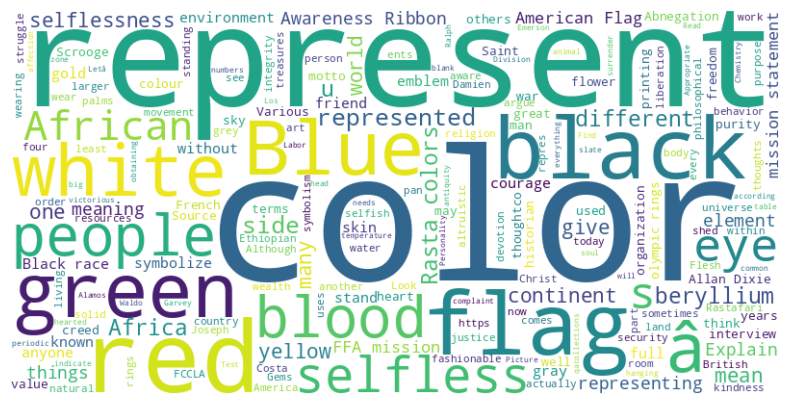

In [56]:
# cell = doc_df.at[29, 'contents']

text = ' '.join(doc_df['contents'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [57]:
import ast

In [58]:
# Convert the lists in 'list_column' to a single string for each row
doc_df['test'] = doc_df['top10_words'].apply(lambda x: ' '.join(x))

doc_df


,id,contents,top10_words,tfidf_vector,Score,test
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385,represents blue color larger security sky univ...
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368,abnegation chicago city color commitment compo...
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020,awareness colors allan dixie represent ribbons...
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960,colors african represents people red yellow af...
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376...",8.8431,colors rings continents olympic represent colo...
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344...",8.7948,flag colors french represent actually american...
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377...",8.7523,colors fccla red represents white action coura...
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331...",8.7057,american colors flag red represent blue repres...
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120...",8.5507,selfless people agree altruistic behavior bett...
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412...",8.4574,color flag represents blue costa blood colors ...


In [59]:
combined_text = ' '.join(doc_df['test'])

# Split the combined text into words and calculate the vocabulary size
words = combined_text.split()
words

['represents',
 'blue',
 'color',
 'larger',
 'security',
 'sky',
 'universe',
 'water',
 'aspects',
 'assigned',
 'abnegation',
 'chicago',
 'city',
 'color',
 'commitment',
 'composed',
 'council',
 'dystopic',
 'entirely',
 'faction',
 'awareness',
 'colors',
 'allan',
 'dixie',
 'represent',
 'ribbons',
 'thoughtco',
 '2017',
 '3456397',
 'com',
 'colors',
 'african',
 'represents',
 'people',
 'red',
 'yellow',
 'africa',
 'aware',
 'black',
 'blood',
 'colors',
 'rings',
 'continents',
 'olympic',
 'represent',
 'colour',
 'answer',
 'appears',
 'background',
 'black',
 'flag',
 'colors',
 'french',
 'represent',
 'actually',
 'american',
 'blue',
 'british',
 'interpretations',
 'mean',
 'colors',
 'fccla',
 'red',
 'represents',
 'white',
 'action',
 'courage',
 'determination',
 'integrity',
 'purpose',
 'american',
 'colors',
 'flag',
 'red',
 'represent',
 'blue',
 'representing',
 'white',
 '13',
 'alternating',
 'selfless',
 'people',
 'agree',
 'altruistic',
 'behavior',


In [60]:
vocabulary = (list(set(words)))

print(len(vocabulary))



202


In [61]:
vocabulary

['forms',
 'composed',
 'background',
 'appropriate',
 'symbolism',
 'sky',
 'creed',
 'egyptian',
 'doesn',
 'emblem',
 'devotion',
 'palms',
 'ego',
 'candle',
 'element',
 'interview',
 'abnegation',
 'goddess',
 'allan',
 'saint',
 'appears',
 'damien',
 'action',
 'blood',
 'altruistic',
 'belgium',
 'ribbons',
 'antiquity',
 'people',
 'courage',
 'eyes',
 'carol',
 'miserly',
 'animal',
 'larger',
 'council',
 'numbers',
 'alamos',
 'joseph',
 'dystopic',
 'ago',
 'rings',
 'look',
 'entirely',
 'exactly',
 'historians',
 'complaint',
 'grey',
 'flag',
 'mean',
 'better',
 'com',
 'art',
 'chicago',
 '1840',
 'ceremony',
 'ffa',
 'race',
 'indicate',
 'isn',
 'flowers',
 'flesh',
 'christmas',
 'used',
 '3456397',
 'british',
 '13',
 'gain',
 'expecting',
 'water',
 'figure',
 '1864',
 'purpose',
 'africa',
 'beryllium',
 'fbla',
 'meant',
 'agree',
 'color',
 'colour',
 'absolution',
 'skin',
 'represented',
 'big',
 'fccla',
 'division',
 'brings',
 'freedom',
 'commitment',
 

In [62]:
doc_df['test'] = doc_df['test'].astype(str)

In [63]:
doc_df['test'][3]

'colors african represents people red yellow africa aware black blood'

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=vocabulary)


matrix1 = vectorizer1.fit_transform(doc_df['test'])
array1 = matrix1.toarray()
size = array1.shape[1]

In [65]:
array1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
array1D = [array1[i] for i in range(30)]

doc_df['feature_vector'] = array1D
doc_df.pop('test')

doc_df


,id,contents,top10_words,tfidf_vector,Score,feature_vector
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376...",8.8431,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344...",8.7948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377...",8.7523,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331...",8.7057,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120...",8.5507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412...",8.4574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [67]:
doc_df["true_label"] = 0

doc_df.loc[:9, 'true_label'] = 1

doc_df

,id,contents,top10_words,tfidf_vector,Score,feature_vector,true_label
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376...",8.8431,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344...",8.7948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377...",8.7523,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331...",8.7057,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120...",8.5507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412...",8.4574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [68]:
doc_df.iloc[0,5]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [69]:
import numpy as np
doc_df['feature_vector'] = doc_df['feature_vector'].apply(lambda x: np.array(x))
doc_df


,id,contents,top10_words,tfidf_vector,Score,feature_vector,true_label
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,8357253,RE: What are the continents that each colour o...,"[colors, rings, continents, olympic, represent...","[0.4703604341917986, 0.4703604341917986, 0.376...",8.8431,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
5,6895760,What the French Flag Colors Represent. Althoug...,"[flag, colors, french, represent, actually, am...","[0.6882472016116852, 0.4588314677411235, 0.344...",8.7948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
6,7133813,What are the FCCLA colors and what do they eac...,"[colors, fccla, red, represents, white, action...","[0.3779644730092272, 0.3779644730092272, 0.377...",8.7523,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7,8175469,The alternating red and whites stripes represe...,"[american, colors, flag, red, represent, blue,...","[0.3312945782245396, 0.3312945782245396, 0.331...",8.7057,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
8,882961,"When you're being selfless, you're thinking of...","[selfless, people, agree, altruistic, behavior...","[0.7223151185146152, 0.3611575592573076, 0.120...",8.5507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9,3644775,What does the flag of Costa Rica mean? Costa R...,"[color, flag, represents, blue, costa, blood, ...","[0.4120816918460671, 0.4120816918460671, 0.412...",8.4574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [70]:
test = doc_df["feature_vector"]

testt = pd.DataFrame(test)

testt

,feature_vector
0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [71]:
df_split = pd.DataFrame(testt['feature_vector'].tolist())
df_split = df_split.rename(columns=dict(zip(df_split.columns, vocabulary)))
df_split

,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [72]:
df_concat = pd.concat([doc_df, df_split], axis=1)
df_concat


,id,contents,top10_words,tfidf_vector,Score,feature_vector,true_label,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best
0,7115523,Blue is on the visual level a calm and peacefu...,"[represents, blue, color, larger, security, sk...","[0.35603449745815596, 0.23735633163877065, 0.2...",10.9385,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,363853,Members of Abnegation take over the public ser...,"[abnegation, chicago, city, color, commitment,...","[0.5669467095138409, 0.1889822365046136, 0.188...",10.5368,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,7115499,"Allan, Dixie. Awareness Ribbons - The Colors a...","[awareness, colors, allan, dixie, represent, r...","[0.4642383454426297, 0.4642383454426297, 0.278...",9.2020,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3386617,Rasta Colors. Many people today wear Rasta col...,"[colors, african, represents, people, red, yel...","[0.4170288281141495, 0.34752402342845795, 0.34...",8.9960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report


X = df_concat.iloc[:, 7:]
y = df_concat['true_label']
dataset = pd.concat([X,y],axis=1)

dataset

,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best,true_label
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
model1 = RandomForestClassifier(max_depth=100, random_state=42)
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, random_state=42)

In [76]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression()

In [77]:
y_pred1 = model1.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred1))

print(classification_report(y_train, y_pred1))



Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [78]:
y_pred2 = model2.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred2))

print(classification_report(y_train, y_pred2))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [79]:
y_pred1

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1])

In [80]:
y_pred2

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1])

In [81]:
X_test

,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best
27,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [82]:
T = X_test[1:2]

a = []


for column in T.columns:
    if T[column].any():
        a.append(column)


print(T[a])

    blood  flag  used  color  freedom  perseverance  colors  represent  \
15      1     1     1      1        1             1       1          1   

    innocence  blue  
15          1     1  


In [83]:
y_test

27    0
15    0
23    0
17    0
8     1
9     1
Name: true_label, dtype: int64

In [84]:
import dice_ml
import warnings
warnings.filterwarnings('ignore')


d = dice_ml.Data(dataframe=dataset, continuous_features=[], outcome_name='true_label')


m = dice_ml.Model(model=model1, backend="sklearn")

exp = dice_ml.Dice(d, m, method="random")

e1 = exp.generate_counterfactuals(X_test[1:2], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(display_sparse_df=True,show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Query instance (original outcome : 0)


,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best,true_label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best,true_label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,-,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,-,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-,0,0,1


In [85]:
e1.visualize_as_list(display_sparse_df=True,show_only_changes=True)

Query instance (original outcome : 0)
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

In [86]:
cf = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '1', 0, 0, 0, 0, 0, 0, '1', 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, '1', 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, '-', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, '1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, '1', 0, 0, 0, 1, '-', 0, 0, 0, 0, 0, '1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0]
copy_X= X_test.copy()
copy_X.loc[len(copy_X.index)] = cf

copy_X


,forms,composed,background,appropriate,symbolism,sky,creed,egyptian,doesn,emblem,devotion,palms,ego,candle,element,interview,abnegation,goddess,allan,saint,appears,damien,action,blood,altruistic,belgium,ribbons,antiquity,people,courage,eyes,carol,miserly,animal,larger,council,numbers,alamos,joseph,dystopic,ago,rings,look,entirely,exactly,historians,complaint,grey,flag,mean,better,com,art,chicago,1840,ceremony,ffa,race,indicate,isn,flowers,flesh,christmas,used,3456397,british,13,gain,expecting,water,figure,1864,purpose,africa,beryllium,fbla,meant,agree,color,colour,absolution,skin,represented,big,fccla,division,brings,freedom,commitment,directly,boss,statement,actually,gray,googled,elements,great,giving,2017,african,answer,benefits,common,does,hands,diane,known,america,aspects,black,meaning,motto,garvey,beloved,american,believe,itâ,rasta,chemistry,fertility,selfless,16,ebenezer,born,backside,birth,scrooge,behavior,organization,friend,affection,authority,deity,gems,arc,green,perseverance,alternating,interpretations,jain,integrity,environment,animals,costa,representing,democracy,mission,extends,person,head,thoughtco,creditor,faction,dishonest,eye,denote,colors,activities,security,emerson,represent,represents,ash,different,acts,innocence,red,essentially,awareness,helpful,olympic,advent,hanging,example,argue,buddhist,dixie,blue,hindu,determination,assigned,christ,universe,explain,french,gold,according,organizing,cold,heart,means,city,blank,country,continents,kindness,yellow,printing,generous,white,aware,best
27,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [87]:
pd.set_option('display.max_columns', None)
T = copy_X[6:7]

a = []


for column in T.columns:
    if T[column].any():
        a.append(column)

T[a]

,blood,larger,rings,flag,used,water,color,fccla,freedom,american,perseverance,alternating,colors,represent,innocence,example,blue,hindu,french,white
6,1,1,1,1,1,1,1,-,1,1,1,1,1,1,1,1,1,-,1,-


In [88]:
T[a].columns.values

array(['blood', 'larger', 'rings', 'flag', 'used', 'water', 'color',
       'fccla', 'freedom', 'american', 'perseverance', 'alternating',
       'colors', 'represent', 'innocence', 'example', 'blue', 'hindu',
       'french', 'white'], dtype=object)

In [89]:
TT = X_test[1:2]

aa = []


for column in TT.columns:
    if TT[column].any():
        aa.append(column)


print(TT[aa])

    blood  flag  used  color  freedom  perseverance  colors  represent  \
15      1     1     1      1        1             1       1          1   

    innocence  blue  
15          1     1  


In [90]:
cf1 = TT[aa].columns.values
cf2 = T[a].columns.values

new_cf = np.concatenate((cf1,cf2),axis=0)

new_cf

array(['blood', 'flag', 'used', 'color', 'freedom', 'perseverance',
       'colors', 'represent', 'innocence', 'blue', 'blood', 'larger',
       'rings', 'flag', 'used', 'water', 'color', 'fccla', 'freedom',
       'american', 'perseverance', 'alternating', 'colors', 'represent',
       'innocence', 'example', 'blue', 'hindu', 'french', 'white'],
      dtype=object)

In [121]:
new_cff = sentence = ' '.join(new_cf)

new_cff = texts+new_cff

new_cff

'The element beryllium is solid at room temperature and is slate gray in color, according to the Los Alamos Labor Chemistry Division. On the periodic table of elements, beryllium is represented as Be.Source...http://www.qacollections.com/What-is-the-color-of-beryllium.he element beryllium is solid at room temperature and is slate gray in color, according to the Los Alamos Labor Chemistry Division. On the periodic table of elements, beryllium is represented as Be.Source... http://www.qacollections.com/What-is-the-color-of-beryllium.blood flag used color freedom perseverance colors represent innocence blue blood larger rings flag used water color fccla freedom american perseverance alternating colors represent innocence example blue hindu french white'

In [119]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [122]:
collections.append((1000,new_cff))

In [123]:
collections

[(1,
  'Blue is on the visual level a calm and peaceful color. We think of it in terms of water, sky and universe. For most of us, sky and water give us a sense of familiarity and consequently of security. For many, the universe represents a larger unity and religion. Therefore, this hue expresses security and spiritual devotion. It is the color that leads to introspection and to our very essence. It represents such ideals as selflessness, sympathy, kindness, compassion and dedication. Blue is assigned to the physical body and, on a larger scale, represents the material aspects of life including the planet earth.'),
 (2,
  "Members of Abnegation take over the public services in the city. The dystopic society of Chicago is ruled by a council of fifty people, composed entirely of representatives from Abnegation, as their faction is the most incorruptible due to their commitment to selflessness. Abnegation's color is grey."),
 (3,
  'Allan, Dixie. Awareness Ribbons - The Colors and What T

In [124]:
with open('collections.tsv', 'w') as f:
    for i,content in collections:
        f.write("{}\t{}\n".format(i,content))


In [125]:
!python /content/drive/MyDrive/convert_collection_to_jsonl.py --collection-path /content/collections.tsv --output-folder /content/drive/MyDrive/top500_index/

Converting collection...
Converted 0 docs, writing into file 1
Done!


In [126]:
!python -m pyserini.index.lucene --collection JsonCollection --input /content/drive/MyDrive/top500_index\
 --index /content/drive/MyDrive/index_Final/ --generator DefaultLuceneDocumentGenerator --threads 1 --storePositions --storeDocvectors --storeRaw

2023-10-11 11:54:57,121 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-10-11 11:54:57,126 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-10-11 11:54:57,127 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-10-11 11:54:57,127 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /content/drive/MyDrive/top500_index
2023-10-11 11:54:57,127 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-10-11 11:54:57,128 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-10-11 11:54:57,128 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 1
2023-10-11 11:54:57,134 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en
2023-10-11 11:54:57,134 INFO  [main] index.Ind

In [127]:
from pyserini.search.lucene import LuceneSearcher


index_path = '/content/drive/MyDrive/index_Final/'

# Initialize the searcher
top501_searcher = LuceneSearcher(index_path)

In [128]:
query

'what color represents selflessness'

In [129]:
hits = top501_searcher.search(query,100)

# Print the results
for hit in hits:
    # if hit.docid == '1000':
    print(f"ID: {hit.docid}, Score: {hit.score}")


ID: 1, Score: 3.9430999755859375
ID: 2, Score: 3.651099920272827
ID: 4, Score: 3.422800064086914
ID: 3, Score: 3.405600070953369
ID: 1000, Score: 3.354599952697754
ID: 5, Score: 3.3282999992370605
ID: 8, Score: 3.262399911880493
ID: 6, Score: 3.2451000213623047
ID: 12, Score: 3.225600004196167
ID: 7, Score: 3.2207000255584717
ID: 13, Score: 3.217400074005127
ID: 10, Score: 3.2118000984191895
ID: 14, Score: 3.1614999771118164
ID: 15, Score: 3.1514999866485596
ID: 16, Score: 3.128000020980835
ID: 20, Score: 3.107599973678589
ID: 18, Score: 3.1013998985290527
ID: 27, Score: 3.0968000888824463
ID: 21, Score: 3.083199977874756
ID: 26, Score: 3.0599000453948975
ID: 25, Score: 3.0580999851226807
ID: 23, Score: 3.0536000728607178
ID: 36, Score: 2.983599901199341
ID: 33, Score: 2.963200092315674
ID: 28, Score: 2.9577999114990234
ID: 90, Score: 2.9300999641418457
ID: 55, Score: 2.9291999340057373
ID: 47, Score: 2.9245998859405518
ID: 92, Score: 2.921999931335449
ID: 32, Score: 2.9117000102996826